<a href="https://colab.research.google.com/github/TheTarr/hw1/blob/zjy_colab/ntu_cv_project1_zjy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#读取图像文件并可视化


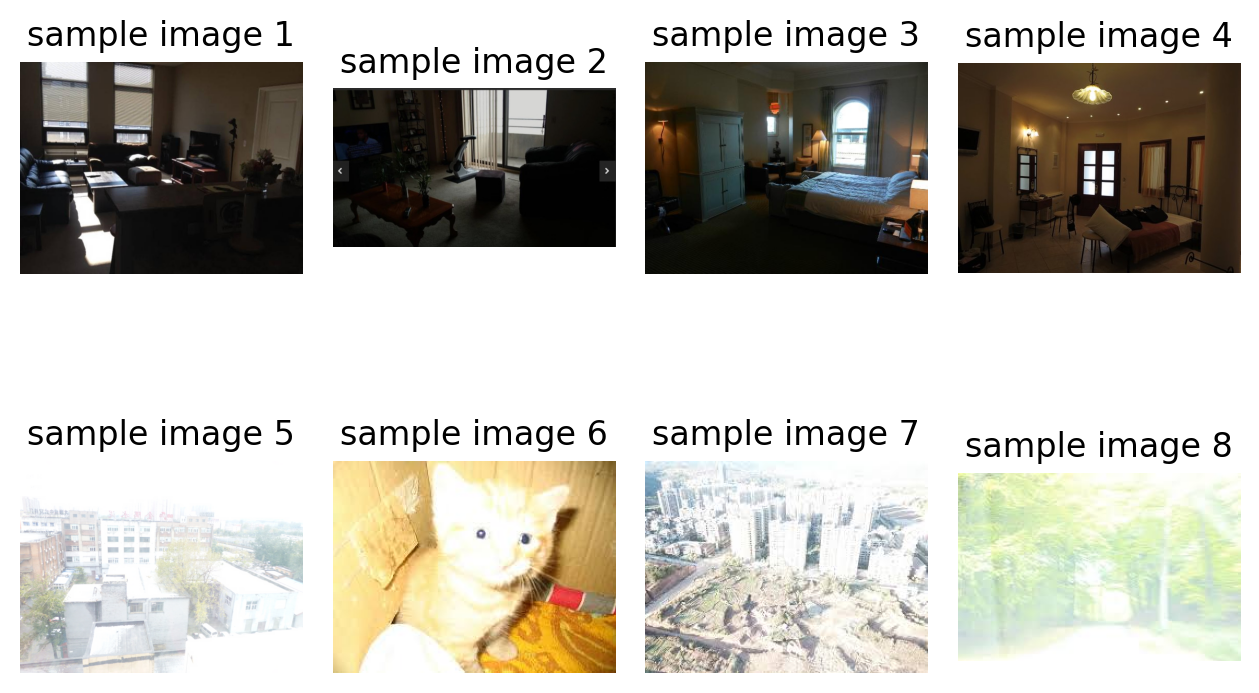

In [1]:
import cv2
import os
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# path
dir_path = '/content/drive/MyDrive/Colab Notebooks/computer vision/project1/sample images'

# get all picture from that path
files = [os.path.join(dir_path, file) for file in os.listdir(dir_path)]
imgs = []

for file in files:
  imgs.append(cv2.imread(file))

plt.figure(dpi=200)
for i,img in enumerate(imgs):
  ax = plt.subplot(2,4,i+1)
  plt.axis('off')
  ax.set_title(f'sample image {i+1}')
  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

# 将RGB图像转换为灰度图，计算直方图，并进行可视化和结果分析


###灰度图转换

In [2]:
# convert RGB image to Gray image
def rgb2gray(img_loc):
  img = cv2.imread(img_loc)
  g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return g_img

g_imgs = []
for file in files:
  g_imgs.append(rgb2gray(file))

###计算直方图

In [3]:
# calculate the histogram data of the image ()
def cal_hist(img):
  pixel_level=np.array(img.tolist()).reshape(-1)
  return pixel_level

hists = []
for g_img in g_imgs:
  hists.append(cal_hist(g_img))

###可视化和结果分析

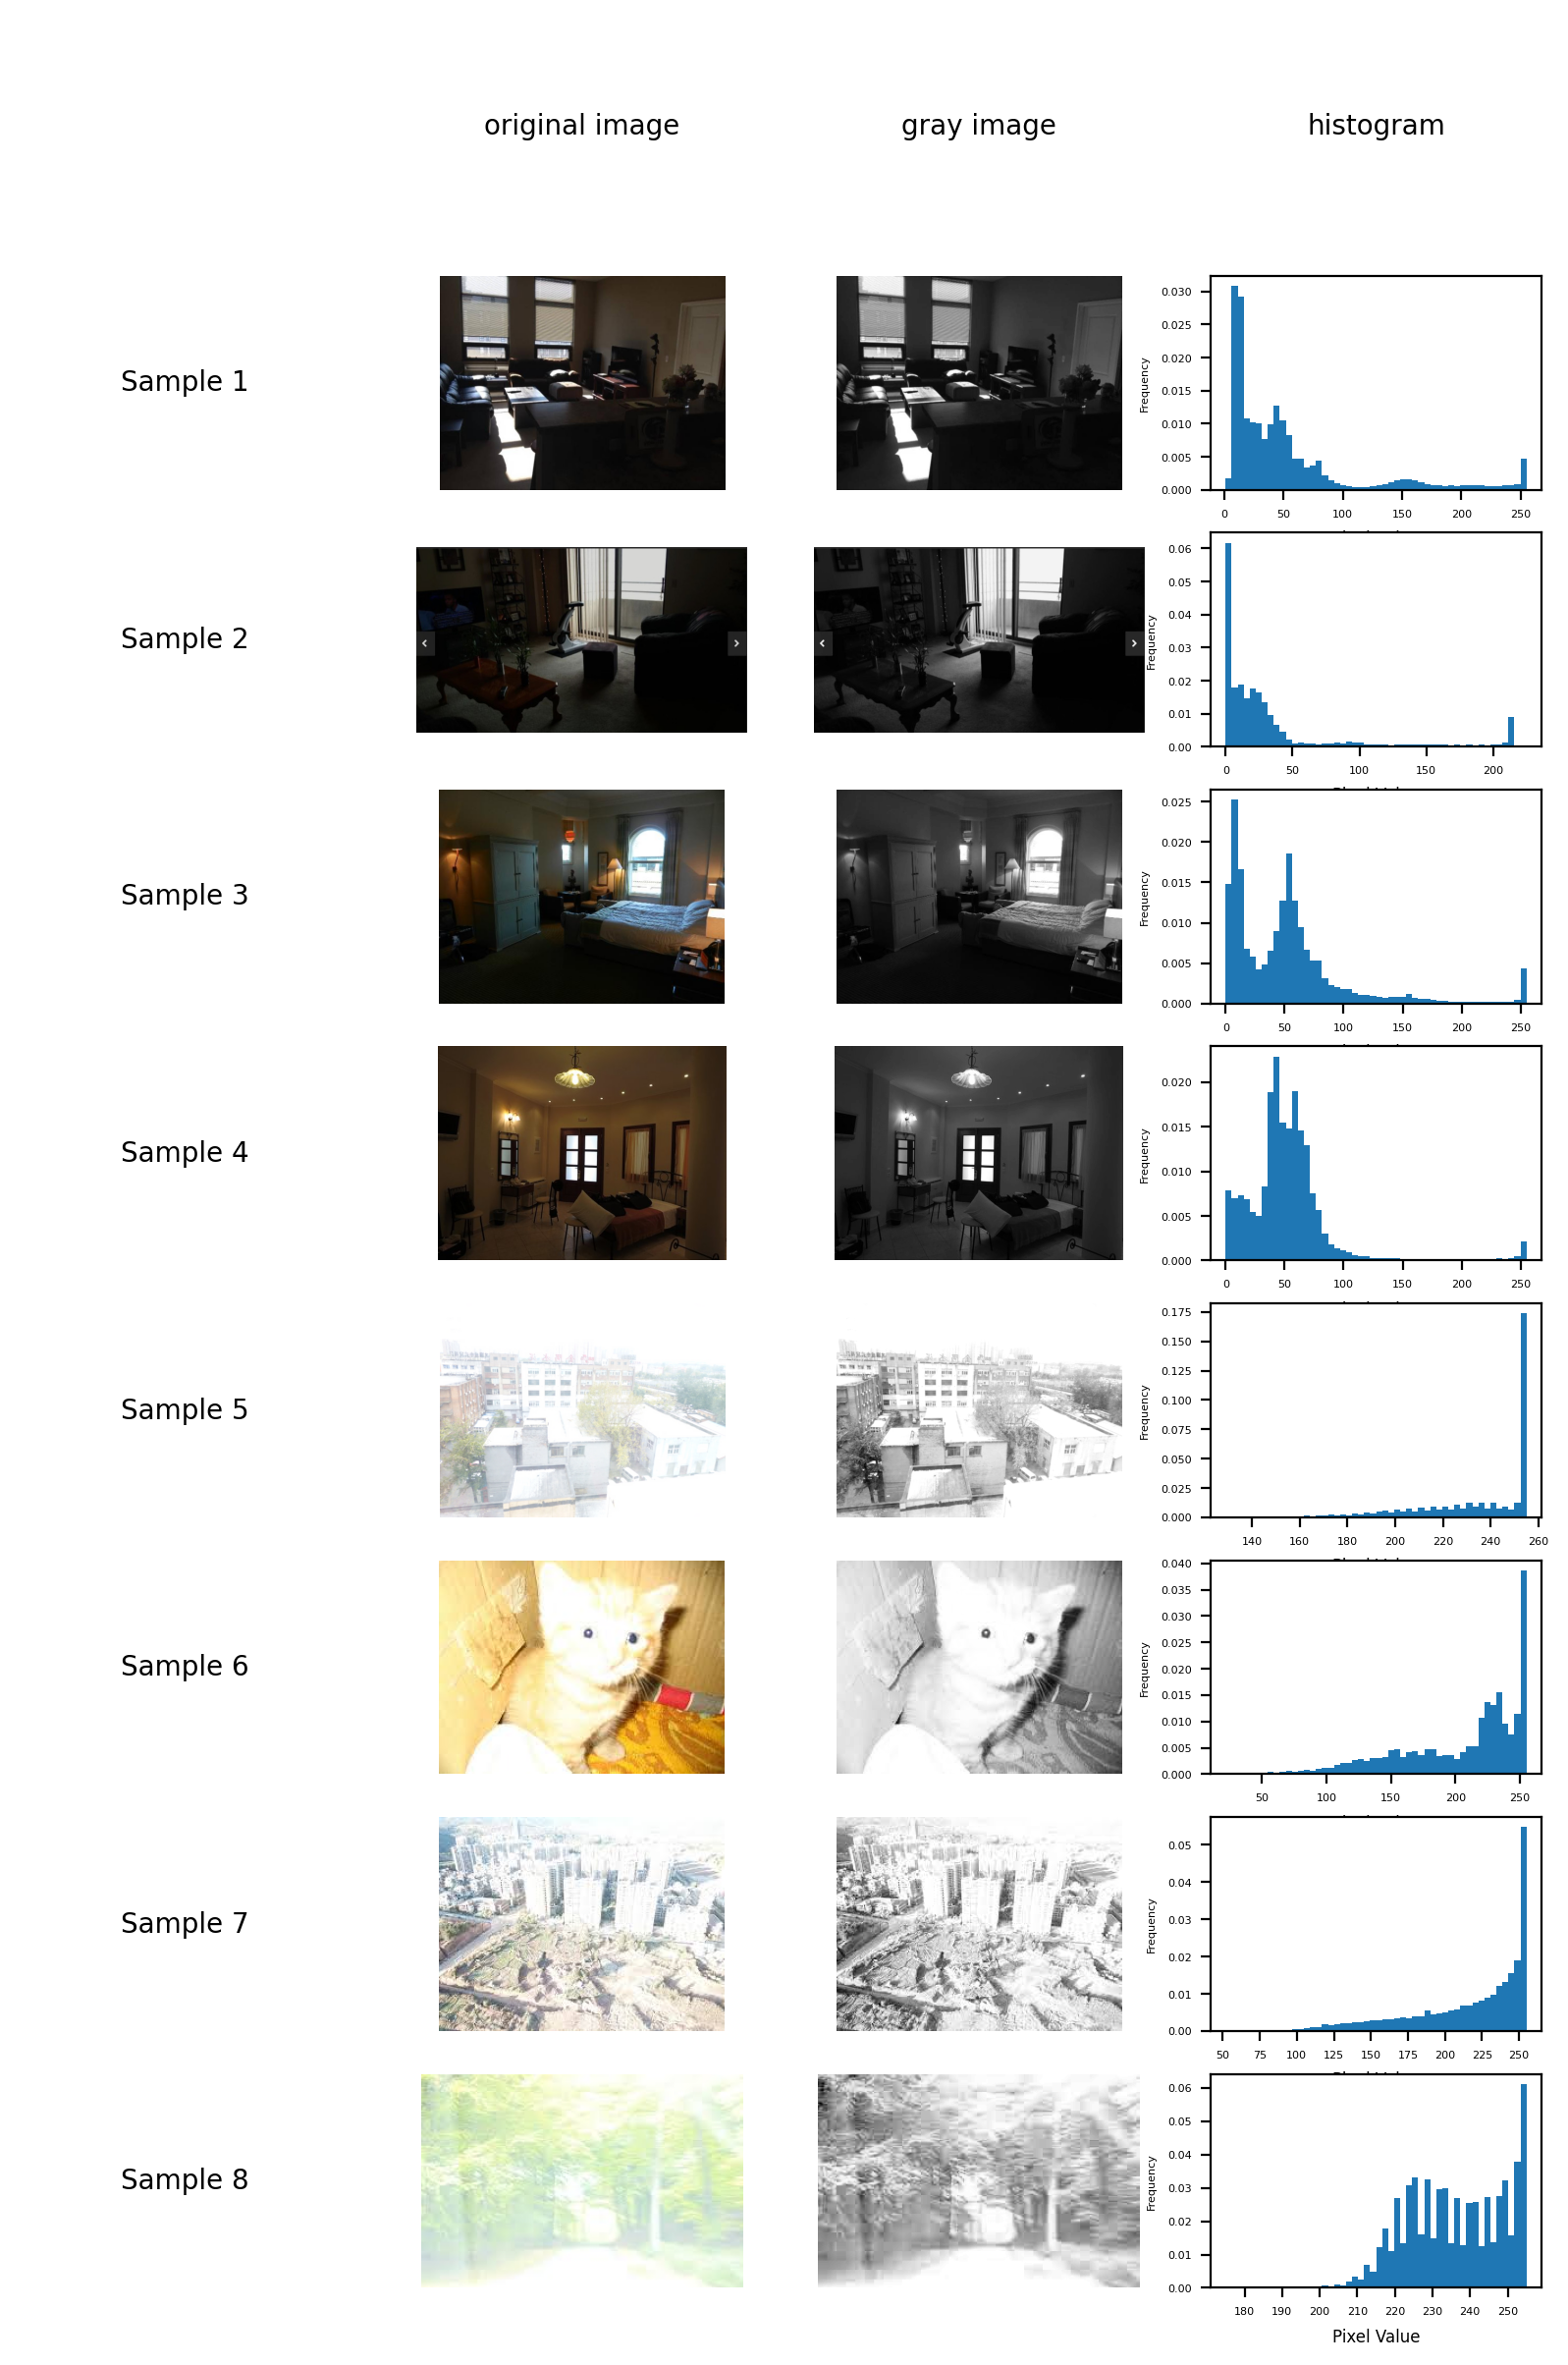

In [107]:
fig, axes = plt.subplots(nrows=9, ncols=4, dpi=200, figsize=(10, 15))

axes[0,0].set_axis_off()
for i in range(len(imgs)):
  axes[i+1,0].text(0.5, 0.5, f'Sample {i+1}', fontsize=10, ha='center', va='center')
  axes[i+1,0].set_axis_off()

col_name = ['original image','gray image','histogram']
for i, name in enumerate(col_name):
  axes[0,i+1].text(0.5, 0.5, name, fontsize=10, ha='center', va='center')
  axes[0,i+1].set_axis_off()

for i, (img, g_img, hist) in enumerate(zip(imgs,g_imgs,hists)):
  i = i+1
  axes[i,1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  axes[i,1].set_axis_off()
  axes[i,2].imshow(g_img,cmap='gray')
  axes[i,2].set_axis_off()
  axes[i,3].hist(hist, bins=50, density=True)
  axes[i,3].set_xlabel('Pixel Value', fontsize=6)
  axes[i,3].set_ylabel('Frequency', fontsize=4)
  axes[i,3].tick_params(axis='x', labelsize=4)
  axes[i,3].tick_params(axis='y', labelsize=4)

#plt.subplots_adjust(wspace=0.02, hspace=0.5)  # 调整水平和垂直间距
#plt.tight_layout()
plt.show()

#实现HE算法，对比处理结果


HE算法:


1.   计算出每个bin有多少个pixel
2.   计算出小于等于k强度的pixel数量
3.   对于每个k强度的像素集合,可以填充多少个bin
4.   计算k的映射值



In [5]:
def HE(channel, L):
    # initialize
    gray_count = [0] * 256
    p_count = [0] * 256
    # get image shape
    height,width = channel.shape
    # count how many pixels in each grayscale value
    channel = np.array(channel, dtype=np.uint8)
    for i in range(height):
        for j in range(width):
          gray_count[channel[i][j]] += 1
    #print(gray_count)
    # sum all pixels and map to 255
    for i in range(len(gray_count)):
        if i == 0:
            p_count[i] = (gray_count[i] / (height * width)) * 255
        else:
            p_count[i] = (gray_count[i] / (height * width)) * 255 + p_count[i-1]
    # get f(x) for each layer
    layer_range = 256 // L
    for l in range(L):
        for i in range(l * layer_range, (l + 1) * layer_range):
            k = 0
            while p_count[i] - k > 0:
                k += 1
            diff = k - p_count[i]
            if diff <= 0.5:
                p_count[i] = k
            else:
                p_count[i] = k - 1
    #print(p_count)
    # do y = f(x) for each layer
    for i in range(height):
        for j in range(width):
            channel[i][j] = p_count[channel[i][j]]
    return channel

在RGB三个维度分别运行HE算法,之后合并三个维度

In [6]:
con_imgs = []
con_hists = []

#先将图片分成RGB三维，之后分别在三维运行HE算法，之后再进行合并
def run_HE_channels(img, L):
  B,G,R = cv2.split(img)
  B_ = HE(B, L)
  G_ = HE(G, L)
  R_ = HE(R, L)
  return cv2.merge([B_,G_,R_])

for img in tqdm(imgs, desc="Processing"):
  con_imgs.append(run_HE_channels(img, 64)) # L equals to 8, means that there are 8 bins in the histogram

for con_img in tqdm(con_imgs, desc="Processing"):
  g_con_img = cv2.cvtColor(con_img, cv2.COLOR_BGR2GRAY)
  con_hists.append(cal_hist(g_con_img))




Processing: 100%|██████████| 8/8 [00:00<00:00, 44.22it/s]


###可视化结果对比

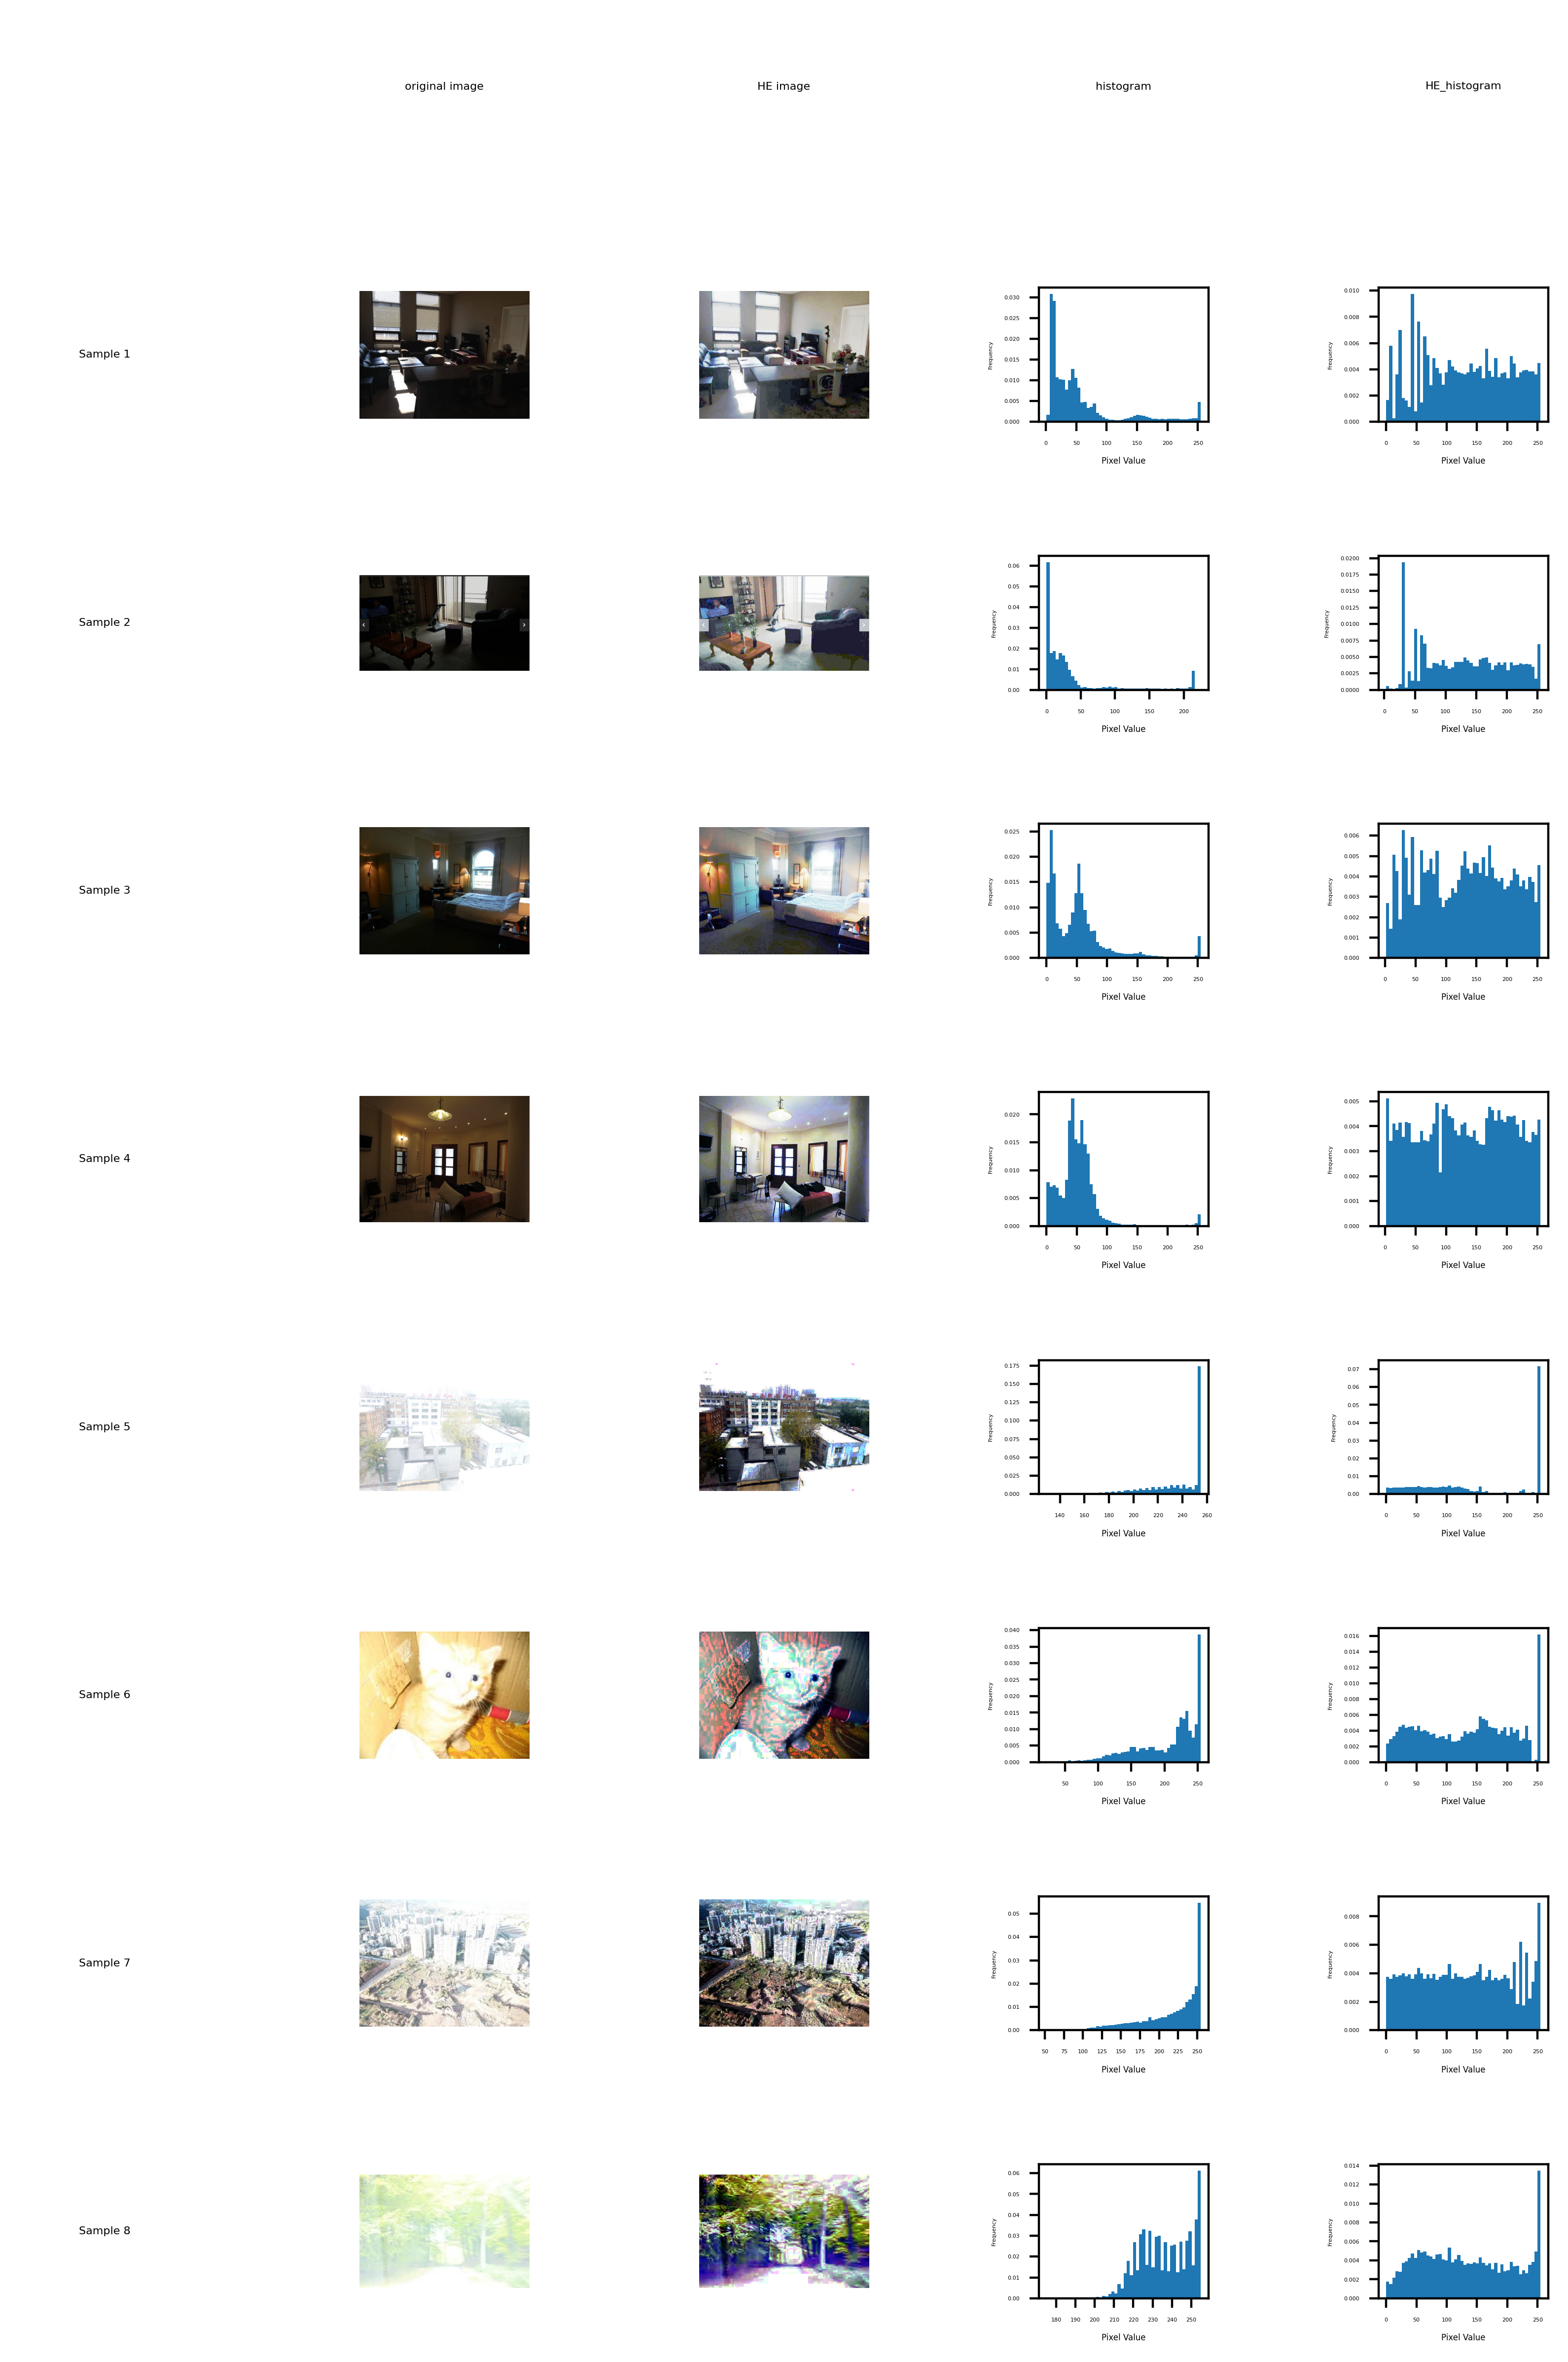

In [108]:
fig, axes = plt.subplots(nrows=9, ncols=5, dpi=400, figsize=(10, 15))

axes[0,0].set_axis_off()
for i in range(len(imgs)):
  axes[i+1,0].text(0.5, 0.5, f'Sample {i+1}', fontsize=4, ha='center', va='center')
  axes[i+1,0].set_axis_off()

col_name = ['original image','HE image','histogram','HE_histogram']
for i, name in enumerate(col_name):
  axes[0,i+1].text(0.5, 0.5, name, fontsize=4, ha='center', va='center')
  axes[0,i+1].set_axis_off()

for i, (img, con_img, hist, con_hist) in enumerate(zip(imgs,con_imgs,hists,con_hists)):
  i = i+1
  axes[i,1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  axes[i,1].set_axis_off()
  axes[i,2].imshow(cv2.cvtColor(con_img, cv2.COLOR_BGR2RGB))
  axes[i,2].set_axis_off()
  axes[i,3].hist(hist, bins=50, density=True)
  axes[i,3].set_xlabel('Pixel Value', fontsize=3)
  axes[i,3].set_ylabel('Frequency', fontsize=2)
  axes[i,3].tick_params(axis='x', labelsize=2)
  axes[i,3].tick_params(axis='y', labelsize=2)
  axes[i,4].hist(con_hist, bins=50, density=True)
  axes[i,4].set_xlabel('Pixel Value', fontsize=3)
  axes[i,4].set_ylabel('Frequency', fontsize=2)
  axes[i,4].tick_params(axis='x', labelsize=2)
  axes[i,4].tick_params(axis='y', labelsize=2)

plt.subplots_adjust(wspace=1, hspace=1)  # 调整水平和垂直间距
plt.show()

###结果分析

放大图像后可以看出，HE算法在图一到图四上表现良好。而图五到图八则出现了明显的色彩断层。

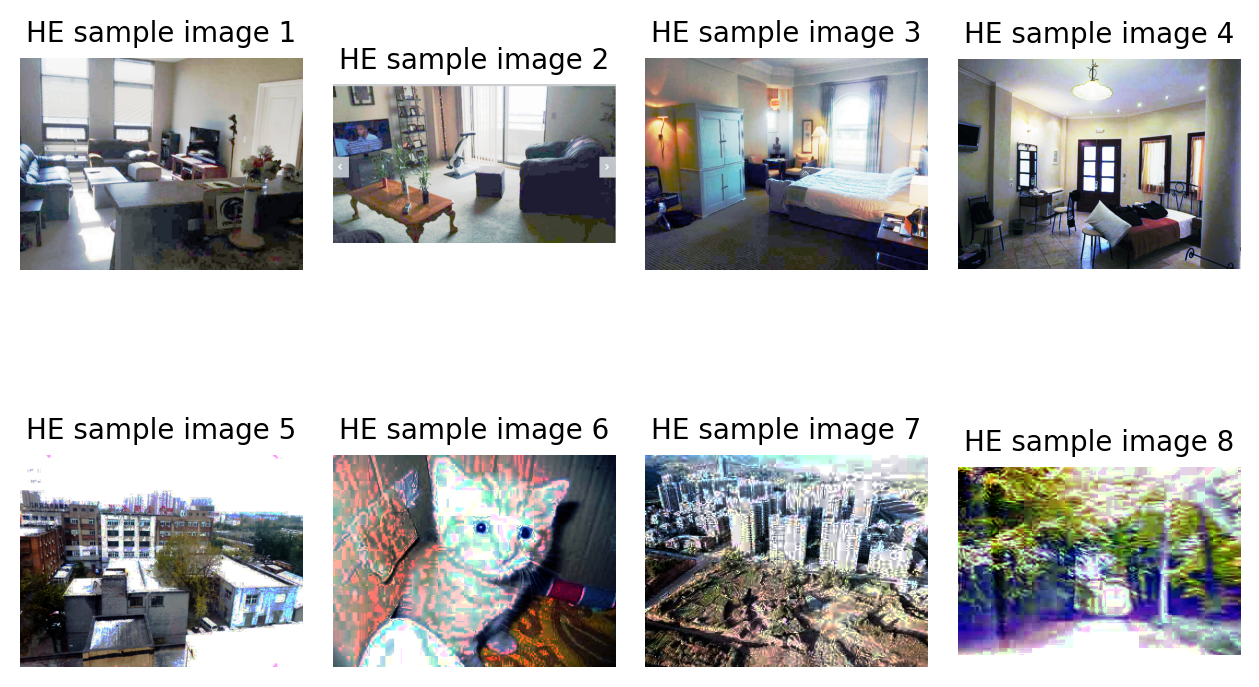

In [8]:
plt.figure(dpi=200)
for i,con_img in enumerate(con_imgs):
  ax = plt.subplot(2,4,i+1)
  plt.axis('off')
  ax.set_title(f'HE sample image {i+1}',fontsize=10)
  ax.imshow(cv2.cvtColor(con_img, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

以图六为例进行分析，通过直方图的变化可以看出虽然图像的对比度（像素分布的距离）被拉大，但是有些曝光强度的像素分布变为0，导致这些区域出现了明显的亮度断层。

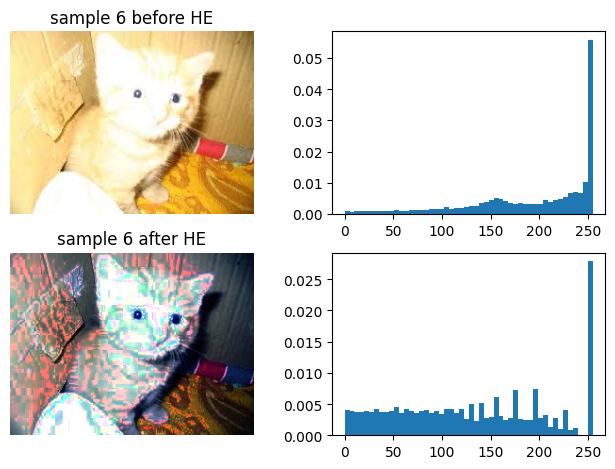

In [109]:
plt.subplot(221)
plt.imshow(cv2.cvtColor(imgs[5], cv2.COLOR_BGR2RGB))
plt.title('sample 6 before HE')
plt.axis('off')
plt.subplot(222)
plt.hist(cal_hist(imgs[5]),bins=50,density=True)
plt.subplot(223)
plt.imshow(cv2.cvtColor(con_imgs[5], cv2.COLOR_BGR2RGB))
plt.title('sample 6 after HE')
plt.axis('off')
plt.subplot(224)
plt.hist(cal_hist(con_imgs[5]),bins=50,density=True)
plt.tight_layout()
plt.show()

#改进原算法（[CLAHE](https://www.analyticsvidhya.com/blog/2022/08/image-contrast-enhancement-using-clahe/)）

The steps of Clahe:
1. Image Partitioning: The input image is divided into smaller, non-overlapping tiles or regions.
2. Histogram Calculation: A histogram is computed for each tile, representing the intensity distribution within that region.
3. Contrast Enhancement: The histogram of each tile is modified to increase the contrast, applying histogram equalization within each tile.
4. Clipping: To prevent over-amplification of noise, contrast-limited clipping is performed on the histogram, limiting the number of pixel values that can be amplified.
5. Interpolation: To avoid abrupt transitions at the tile boundaries, the enhanced tiles are interpolated to create the final output image.



###Clahe的代码实现

In [82]:
def clip_histogram(hist, clip_limit):
    bins = len(hist)
    excess = 0

    for i in range(bins):
        if hist[i] > clip_limit:
            excess += hist[i] - clip_limit
            hist[i] = clip_limit

    mean_excess = excess / bins
    for i in range(bins):
        hist[i] += mean_excess

    return hist

def create_histogram(image, bins=256):
    hist = np.zeros(bins)

    for pixel_value in image.flatten():
        hist[pixel_value] += 1

    return hist

def CLAHE(img, clip_limit, grid_size):
    rows, cols = img.shape
    tile_rows, tile_cols = grid_size
    tile_width = cols // tile_cols
    tile_height = rows // tile_rows

    # create a zero 2D image array for the output
    result_img = np.zeros_like(img)

    for i in range(tile_rows):
        for j in range(tile_cols):
            tile = img[i * tile_height:(i + 1) * tile_height, j * tile_width:(j + 1) * tile_width]
            # transfer tile image to tile histogram
            hist = create_histogram(tile)
            # apply the clipping limit
            hist = clip_histogram(hist, clip_limit)
            # apply HE algorithm on the tile
            cdf = np.cumsum(hist) / np.sum(hist)

            for m in range(tile_height):
                for n in range(tile_width):
                    pixel_value = tile[m, n]
                    result_pixel = int(cdf[pixel_value] * (256 - 1))
                    result_img[i * tile_height + m, j * tile_width + n] = result_pixel

    return result_img

###Clahe算法在图五到图八上和原来的HE算法的可视化对比

In [78]:
# input: img output: result_img
def run_clahe(img, clip_limit, grid_size):
  B,G,R = cv2.split(img)
  B_ = CLAHE(B, clip_limit, grid_size)
  G_ = CLAHE(G, clip_limit, grid_size)
  R_ = CLAHE(R, clip_limit, grid_size)
  return cv2.merge([R_,G_,B_])

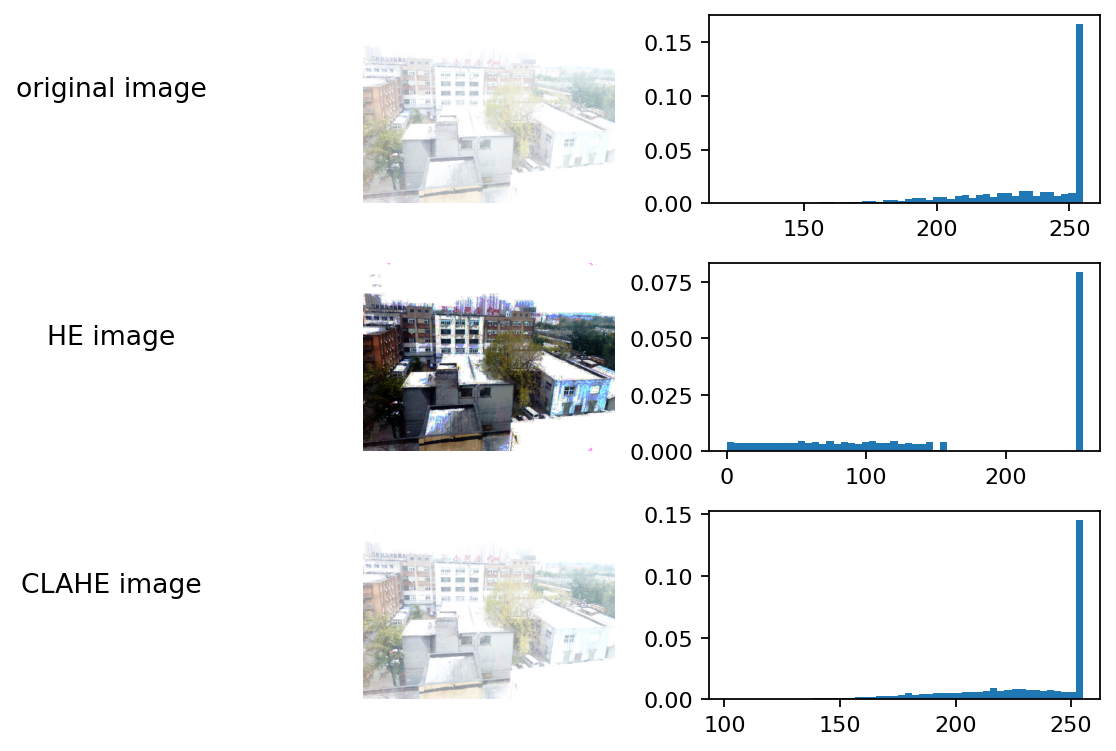

In [104]:
img=imgs[4]
he_img5 = con_imgs[4]
clahe_img5 = run_clahe(img,clip_limit=8,grid_size=(8,8))
plt.figure(dpi=160)
plt.subplot(321)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('original image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(322)
plt.hist(cal_hist(img),bins=50,density=True)
plt.subplot(323)
plt.imshow(cv2.cvtColor(he_img5, cv2.COLOR_BGR2RGB))
plt.title('HE image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(324)
plt.hist(cal_hist(he_img5),bins=50,density=True)
plt.subplot(325)
plt.imshow(clahe_img5)
plt.title('CLAHE image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(326)
plt.hist(cal_hist(clahe_img5),bins=50,density=True)
plt.tight_layout()
plt.show()

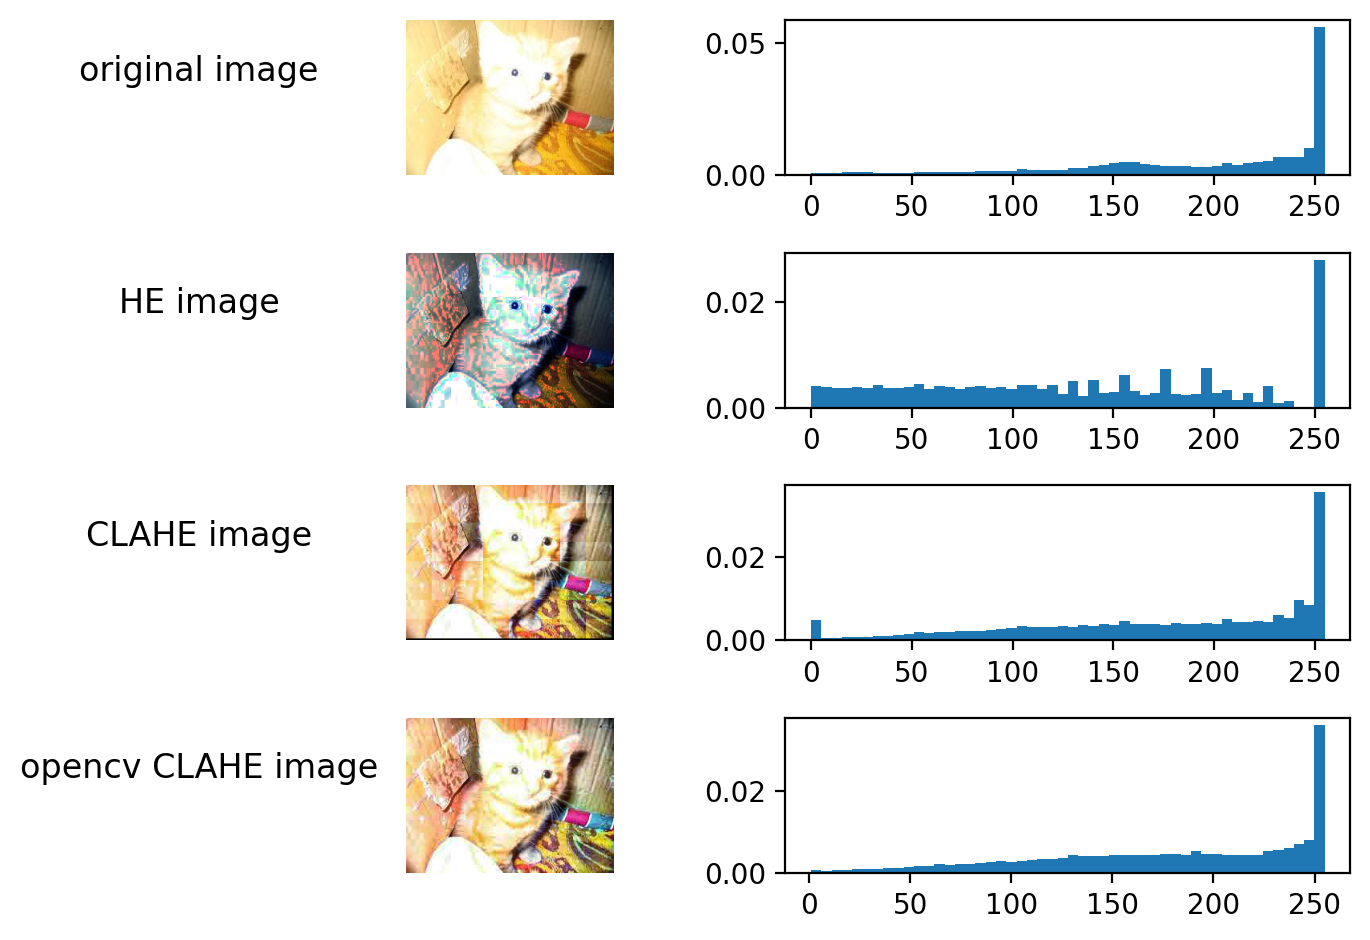

In [102]:
img=imgs[5]
he_img5 = con_imgs[5]
clahe_img5 = run_clahe(img,clip_limit=8,grid_size=(8,8))
plt.figure(dpi=200)
plt.subplot(421)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('original image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(422)
plt.hist(cal_hist(img),bins=50,density=True)
plt.subplot(423)
plt.imshow(cv2.cvtColor(he_img5, cv2.COLOR_BGR2RGB))
plt.title('HE image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(424)
plt.hist(cal_hist(he_img5),bins=50,density=True)
plt.subplot(425)
plt.imshow(clahe_img5)
plt.title('CLAHE image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(426)
plt.hist(cal_hist(clahe_img5),bins=50,density=True)
clahe = cv2.createCLAHE(clipLimit =4.0, tileGridSize=(8,8))
B,G,R = cv2.split(img)
R_ = clahe.apply(R)
B_ = clahe.apply(B)
G_ = clahe.apply(G)
img_ = cv2.merge([R_,G_,B_])
plt.subplot(427)
plt.imshow(img_)
plt.title('opencv CLAHE image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(428)
plt.hist(cal_hist(img_),bins=50,density=True)
plt.tight_layout()
plt.show()

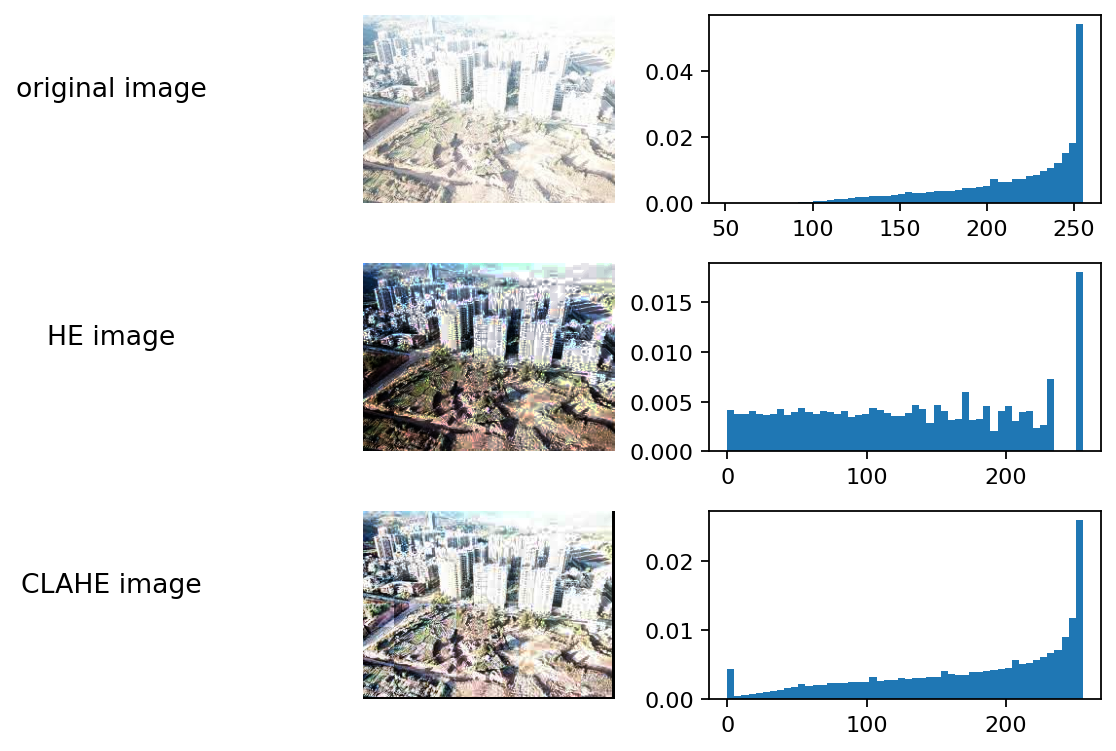

In [105]:
img=imgs[6]
he_img5 = con_imgs[6]
clahe_img5 = run_clahe(img,clip_limit=8,grid_size=(8,8))
plt.figure(dpi=160)
plt.subplot(321)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('original image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(322)
plt.hist(cal_hist(img),bins=50,density=True)
plt.subplot(323)
plt.imshow(cv2.cvtColor(he_img5, cv2.COLOR_BGR2RGB))
plt.title('HE image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(324)
plt.hist(cal_hist(he_img5),bins=50,density=True)
plt.subplot(325)
plt.imshow(clahe_img5)
plt.title('CLAHE image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(326)
plt.hist(cal_hist(clahe_img5),bins=50,density=True)
plt.tight_layout()
plt.show()

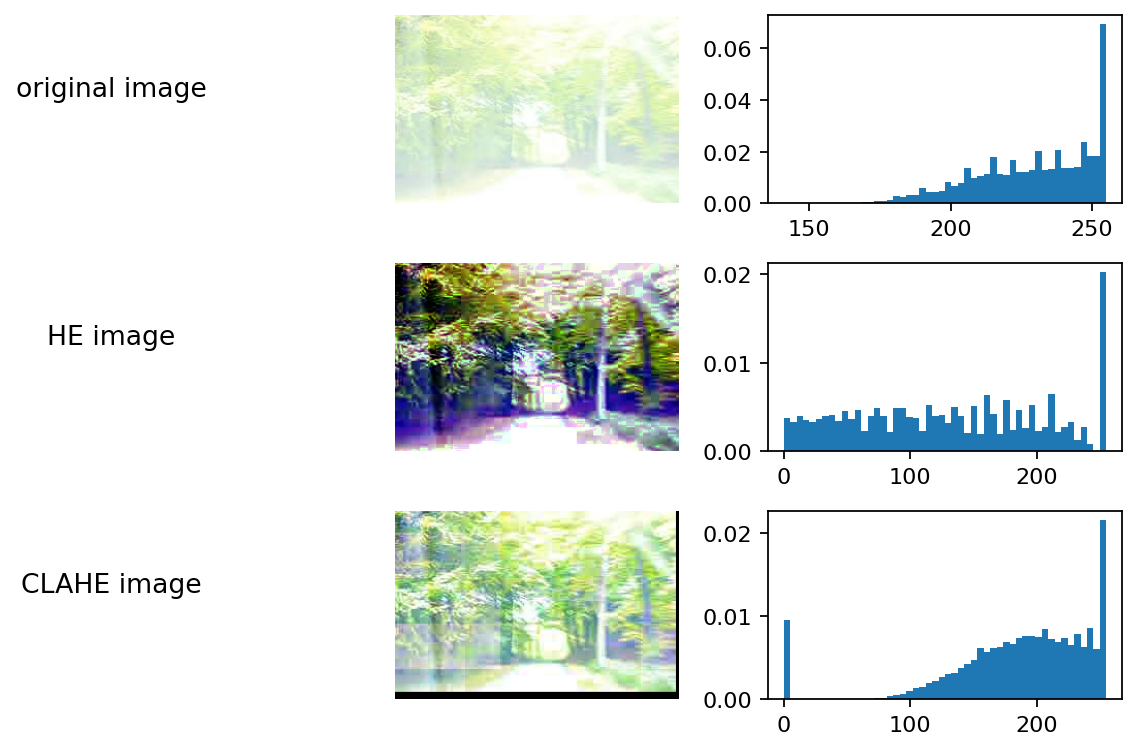

In [106]:
img=imgs[7]
he_img5 = con_imgs[7]
clahe_img5 = run_clahe(img,clip_limit=8,grid_size=(8,8))
plt.figure(dpi=160)
plt.subplot(321)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('original image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(322)
plt.hist(cal_hist(img),bins=50,density=True)
plt.subplot(323)
plt.imshow(cv2.cvtColor(he_img5, cv2.COLOR_BGR2RGB))
plt.title('HE image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(324)
plt.hist(cal_hist(he_img5),bins=50,density=True)
plt.subplot(325)
plt.imshow(clahe_img5)
plt.title('CLAHE image',x=-1,y=0.5)
plt.axis('off')
plt.subplot(326)
plt.hist(cal_hist(clahe_img5),bins=50,density=True)
plt.tight_layout()
plt.show()